In [1]:
#in this project I will try to analyze the impact of SAT score in NY schools
import pandas as pd
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}
#read each of the datasets into a pandas dataframe added into a dictionary
#each dataframe will have the base of the filename as the key
for data_file in data_files:
    data[data_file.split(".")[0]] = pd.read_csv("schools/"+data_file)


In [2]:
#print(data["sat_results"].head())

In [3]:
#for key in data:
#    print(key)
#    print(data[key].head())

In [4]:
#when reading survey data we should notice that this txt file is tab delimited and uses windows-1252 encoding
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding="windows-1252")
#combine two surveys into one
survey = pd.concat([all_survey, d75_survey], axis=0)
#print(survey.head())

In [5]:
survey["DBN"] = survey["dbn"]
survey = survey.loc[:,["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]]
data["survey"] = survey
#data["survey"].head()

In [6]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]
#data["hs_directory"].head(1)

In [7]:
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(lambda x: str(x).zfill(2))
data["class_size"]["DBN"] =  data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
#data["class_size"].head(1)

In [8]:
data["sat_results"]["SAT Math Avg. Score"] = pd.to_numeric(data["sat_results"]["SAT Math Avg. Score"], errors="coerce")
data["sat_results"]["SAT Critical Reading Avg. Score"] = pd.to_numeric(data["sat_results"]["SAT Critical Reading Avg. Score"], errors="coerce")
data["sat_results"]["SAT Writing Avg. Score"] = pd.to_numeric(data["sat_results"]["SAT Writing Avg. Score"], errors="coerce")
data["sat_results"]["sat_score"] = data["sat_results"]["SAT Math Avg. Score"] + data["sat_results"]["SAT Critical Reading Avg. Score"] + data["sat_results"]["SAT Writing Avg. Score"]
#data["sat_results"].head()

In [9]:
#data["hs_directory"].head()

In [10]:
import re
def extract_lat(loc):
    tmp = re.findall("\(.+, .+\)", loc)[0]
    tmp = tmp.replace("(", "")
    tmp = tmp.replace(")", "")
    tmp = tmp.replace(" ", "")
    return tmp.split(",")[0]

def extract_lon(loc):
    tmp = re.findall("\(.+, .+\)", loc)[0]
    tmp = tmp.replace("(", "")
    tmp = tmp.replace(")", "")
    tmp = tmp.replace(" ", "")
    return tmp.split(",")[1]

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(lambda x: extract_lat(x))
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(lambda x: extract_lon(x))
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [11]:
#data["hs_directory"].head(1)

In [12]:
#codensing class size so that each row has a unique DBN value
#the unique values for GRADE column in class_size dataset
data["class_size"]["GRADE "].unique()
#as we are researching on the highschool level so we only need levels 09-12
class_size = data["class_size"]
class_size = class_size[class_size['GRADE ']=='09-12']
class_size = class_size[class_size['PROGRAM TYPE']=='GEN ED']
#class_size.head(5)

#computing average class sizes
grouped = class_size.groupby("DBN")

import numpy as np
grouped = grouped.aggregate(np.mean)
class_size = grouped
#DBN column is now an index for dataframe as a result of groupby
class_size.reset_index(inplace=True)
data['class_size'] = class_size

In [13]:
#condensing demographics
#as we want the most recent data so we choose to have only where schoolyear=20112012
data['demographics'] = data['demographics'][data['demographics']['schoolyear']==20112012]
#data['demographics']

In [14]:
#condensing graduation
data['graduation'] = data['graduation'][data['graduation']['Cohort']=='2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic']=='Total Cohort']
#data['graduation'].head()

In [15]:
#convert 3 columns in ap_2010 to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for c in cols:
    pd.to_numeric(data['ap_2010'][c], errors='coerce')
#data['ap_2010'].head()

In [16]:
#combine datasets in a way that we have the maximum number of rows and at the same time the less 
#number of null values
combined = data['sat_results']
combined = combined.merge(data['ap_2010'], how='left', on='DBN')
combined = combined.merge(data['graduation'], how='left', on='DBN')
#combined.head()
#combined.shape

In [17]:
combined = combined.merge(data['class_size'], how='inner', on='DBN')
combined = combined.merge(data['demographics'], how='inner', on='DBN')
combined = combined.merge(data['survey'], how='inner', on='DBN')
combined = combined.merge(data['hs_directory'], how='inner', on='DBN')
#combined.head()
#combined.shape

In [18]:
#filling the missing values
means = combined.mean()
combined = combined.fillna(means)
combined = combined.fillna(0)
#combined.head()

In [19]:
#Adding a school distric column
def first_two(x):
    return x[:2]
combined['school_dist'] = combined['DBN'].apply(first_two)
#combined.head()

In [20]:
#finding correlations
correlations = combined.corr()
correlations = correlations.loc[:,"sat_score"]
print(correlations[correlations>0.25])

SAT Critical Reading Avg. Score      0.986820
SAT Math Avg. Score                  0.972643
SAT Writing Avg. Score               0.987771
sat_score                            1.000000
Total Cohort                         0.325144
NUMBER OF STUDENTS / SEATS FILLED    0.394626
NUMBER OF SECTIONS                   0.362673
AVERAGE CLASS SIZE                   0.381014
SIZE OF LARGEST CLASS                0.314434
total_enrollment                     0.367857
asian_num                            0.475445
asian_per                            0.570730
white_num                            0.449559
white_per                            0.620718
male_num                             0.325520
female_num                           0.388631
N_s                                  0.423463
N_t                                  0.291463
N_p                                  0.421530
saf_t_11                             0.313810
saf_s_11                             0.337639
aca_s_11                          

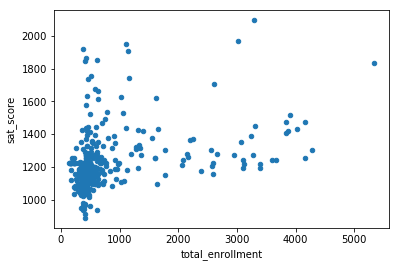

In [21]:
import matplotlib.pyplot as plt
combined.plot.scatter(x="total_enrollment", y="sat_score")
plt.show()

In [46]:
#in last plot we saw a cluster of schools with all low sat scores that 
#makes the sat score correlate with total enrollment so lets observe them closer
cond = (combined["sat_score"]<1000) & (combined["total_enrollment"]<1000)
low_enrollment = combined[cond]
print(low_enrollment.loc[:,["SCHOOL NAME"]])

                                          SCHOOL NAME
91                INTERNATIONAL COMMUNITY HIGH SCHOOL
125               ACADEMY FOR LANGUAGE AND TECHNOLOGY
126                   BRONX INTERNATIONAL HIGH SCHOOL
139             KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141             INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176  PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179                     HIGH SCHOOL OF WORLD CULTURES
188                BROOKLYN INTERNATIONAL HIGH SCHOOL
225     INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
237                        IT TAKES A VILLAGE ACADEMY
253                         MULTICULTURAL HIGH SCHOOL
286            PAN AMERICAN INTERNATIONAL HIGH SCHOOL


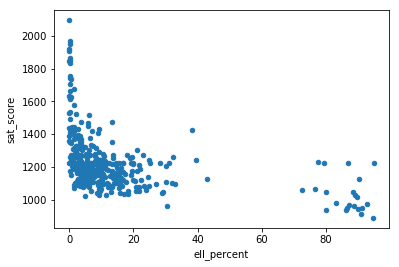

In [51]:
#from last investigation, turns out that most of the schools in the list with low sat_scores are the schools with more
#english language learners so let's continue with plotting ell_percent against sat_score
combined.plot.scatter("ell_percent", "sat_score")
plt.show()

/Users/saeed/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/saeed/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


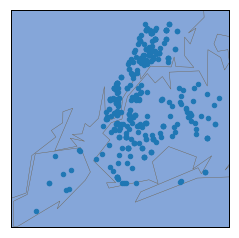

In [65]:
#showed that english language learnenrs percent and sat score are more strongly related as the relation is more linear
#lets map percent of english language learners on the map
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True)

plt.show()

/Users/saeed/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/saeed/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


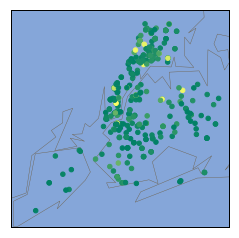

In [70]:
#plotting out statistics
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined["lon"].tolist()
latitudes = combined["lat"].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined["ell_percent"], cmap="summer")

plt.show()

In [72]:
#let's calculate district-level statistics
import numpy
districts = combined.groupby("school_dist").aggregate(numpy.mean)
districts.reset_index(inplace=True)
print(districts.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  Total Cohort  CSD  \
0              439.333333  1354.500000     93.500000  1.0   
1              424.832836  1295.638184    158.647849  2.0   
2              426.915672  1293.443035    183.384409  3.0   
3              405.714286  1224.142857    113.857143  4.0   
4              419.666098  1285.062687    143.677419  5.0   

   NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  AVERAGE CLASS SIZE  \
0                         115.244241            5.148538           22.675415   
1                         149.818949          

/Users/saeed/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/saeed/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


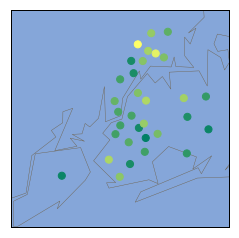

In [73]:
#plotting ell-percent by district
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["ell_percent"], cmap="summer")

plt.show()